# ECS759P Lab 2: Tree search algorithms (BFS and DFS)

In this lab, we are going to implement and compare two of our basic search algorithms, namely Breadth First Search (**BFS**) and Depth First Search (**DFS**) on a real-world problem.

But first, a quick tutorial on graph visualisation!

## 0. How to represent a graph (a tutorial)

Most of the search algorithms we study need to be applied to problems that can be modelled as graphs, where the graph represents the state space of the problem.   

You might be familiar with modelling a "tree", which is a graph without any cycles. While modelling a tree may be relatively simple, there exists many ways to encode a graph.

We can for instance use nested dictionaries to represent a graph, as in the following example:

In [1]:
simple_graph = {"node_A" : {"node_B" : 10, "node_C" : 75, "node_D" : 20},
                "node_B" : {"node_A" : 10, "node_C" : 35, "node_D" : 25},
                "node_C" : {"node_B" : 35, "node_A" : 75, "node_D" : 30},
                "node_D" : {"node_B" : 25, "node_A" : 20, "node_C" : 30}}

The above dictionary contains all the information required to represent a graph. Each *key* of the `simple_graph` dictionary corresponds to a *vertex* `v`, a.k.a. a *node*. The *value* of a vertex is itself a dictionary, containing the information about the *neighbours* of that vertex. For instance `node_A` is connected to `node_B`, `node_C` and `node_D` via *edges*, a.k.a., *links*,  having *step costs*, a.k.a. *weights* of 10, 75, and 20, respectively.

An advantage of this representation is the ease of access to all the information. A disadvantage is that it is rather memory-inefficient (note the size of the dictionary to represent a graph of only 4 nodes and 6 links), as it contains a lot of redundant information.


As a warm up, with a pen and paper or in your head, try to visualise the graph and then find the shortest path from `node_A` to `node_C`. For the (simple) example above, **once** you visualize the graph, it is quite straightforward to analyse it. However, this can quickly show its limitations. For instance, let's try to visualise the following example:

In [2]:
more_complex_graph = {"vertex1" : {"vertex2" : 24, "vertex3" : 52, "vertex0" : 17},
                      "vertex2" : {"vertex0" : 14, "vertex3" : 64, "vertex5" : 11, "vertex1" : 24, "vertex4": 41},
                      "vertex0": {"vertex1" : 17, "vertex2" : 14, "vertex5" : 44},
                      "vertex3": {"vertex1" : 52, "vertex2" : 64},
                      "vertex4" : {"vertex2" : 41},
                      "vertex5": {"vertex2" : 11, "vertex0" : 44}}

It's quite difficult isn't it?

That is why we are going to use a useful python library called **[NetworkX](https://networkx.github.io/documentation/stable/)**. This library provides some useful tools to build, analyse and display graphs. One of its classes allowing to encode a graph is called `Graph`. Although there exists once again a lot of ways to generate graphs with this library, we are going to go through the basics. Consider the following example:

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

dummy_nx_graph = nx.Graph()
dummy_nx_graph.add_node("Hello")
dummy_nx_graph.add_node("amigo.")

Here we just added two nodes (or vertices). Let's visualise them:

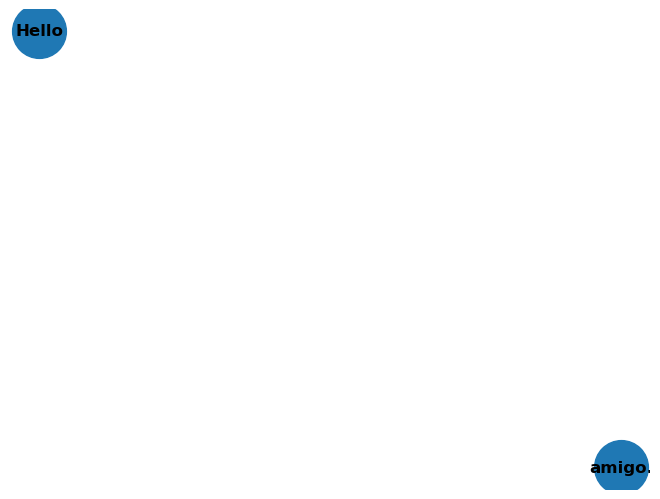

In [4]:
nx.draw(dummy_nx_graph, with_labels=True, node_size=1500, font_weight='bold')
plt.show()

Well, two nodes alone, without any edge between them, ain't that interesting! So let's add a link:

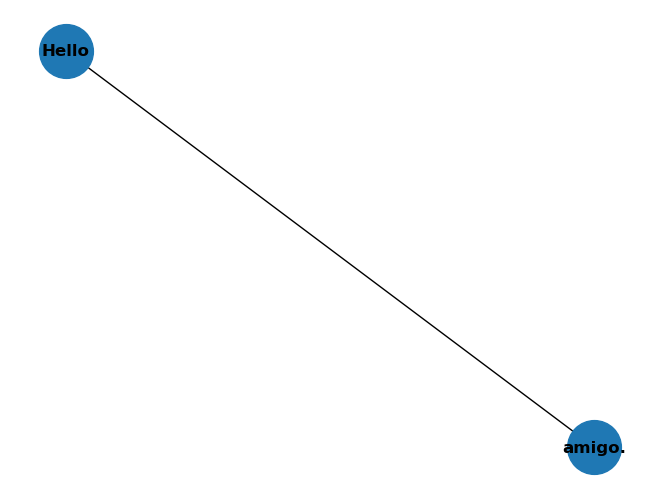

In [5]:
dummy_nx_graph.add_edge("Hello", "amigo.")
nx.draw(dummy_nx_graph, with_labels=True, node_size=1500, font_weight='bold')
plt.show()

We can also make our graph grow just by adding edges (which will also create the necessary new nodes for us).

We can add weights (step costs) to each of the existing edges, or alternatively, specify the weight when creating an edge:

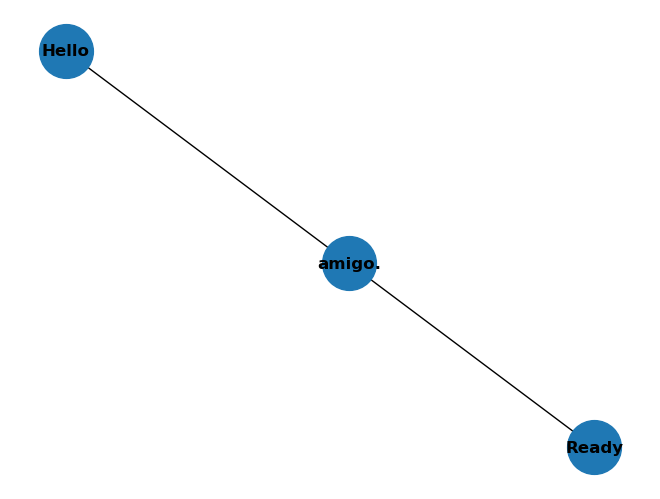

In [6]:
dummy_nx_graph["Hello"]["amigo."]['weight'] = 1 # adding a weight to an existing edge
dummy_nx_graph.add_edge("amigo.",  "Ready", weight=1.5) # adding a new edge and specifying its weight
nx.draw(dummy_nx_graph, with_labels=True, node_size=1500, font_weight='bold')
plt.show()

Adding nodes or edges one by one would be too painful for big graphs. Instead, we can add multiple edges at a once from an iterable container:

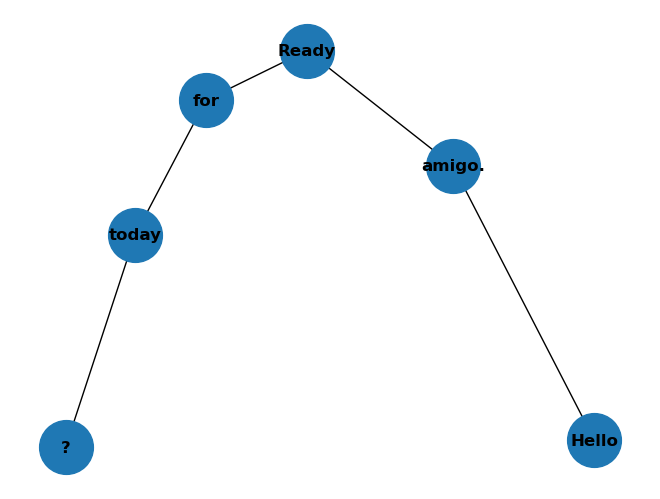

In [7]:
dummy_nx_graph.add_nodes_from(["Ready", "for"])
dummy_nx_graph.add_weighted_edges_from([("Ready", "for", 4.2),
                                        ("for", "today", 9.8),
                                        ("today", "?", 7)])
nx.draw(dummy_nx_graph, with_labels=True, node_size=1500, font_weight='bold')
plt.show()

**Q. By filling the gaps below, create and visualise the equivalent of `simple_graph` that we specified using nested dictionaries at the beginning of this lab.**

#### <font color='blue'> Solution </font>

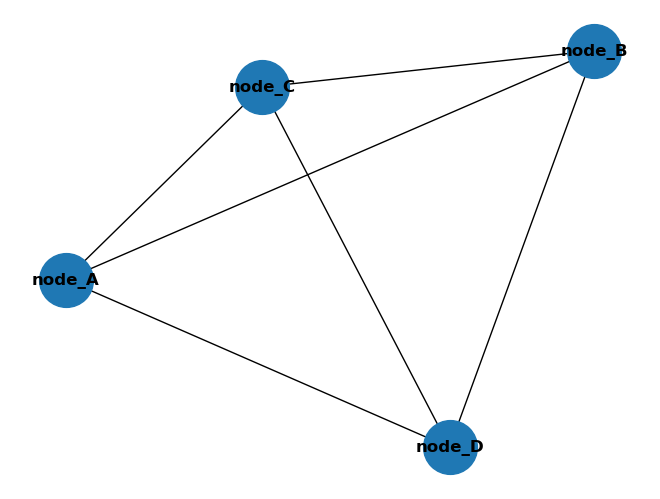

In [8]:
# Your code to create and display simple_graph:
simple_nx_graph = nx.Graph()

for node, connected_elem in simple_graph.items():
    for connected_node, weight in connected_elem.items():
        simple_nx_graph.add_edge(node, connected_node, weight = weight)

nx.draw(simple_nx_graph, with_labels=True, node_size=1500, font_weight='bold')
plt.show()

This is more convenient than reading and understanding a graph from a structure like a nested dictionary.

However, the visualisation still leaves something to be desired: the weights are not appearing! Let's solve this by first drawing only the vertices and then the weighted edges.

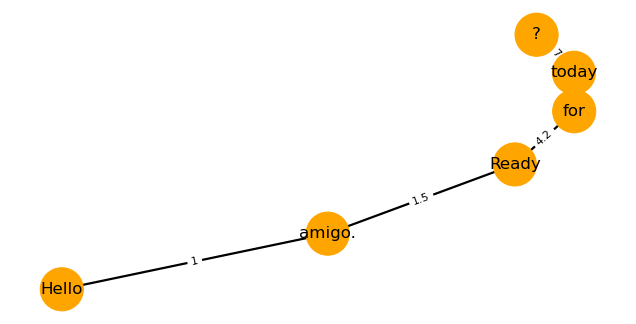

In [9]:
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size):
  # Allocate the given fig_size in order to have space for each node
  plt.figure(num=None, figsize=fig_size, dpi=80)
  plt.axis('off')
  # Compute the position of each vertex in order to display it nicely
  nodes_position = nx.spring_layout(networkx_graph)
  # You can change the different layouts depending on your graph
  # Extract the weights corresponding to each edge in the graph
  edges_weights  = nx.get_edge_attributes(networkx_graph,'weight')
  # Draw the nodes (you can change the color)
  nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size,
                         node_color = ["orange"]*networkx_graph.number_of_nodes())
  # Draw only the edges
  nx.draw_networkx_edges(networkx_graph, nodes_position,
                         edgelist=list(networkx_graph.edges), width=2)
  # Add the weights
  nx.draw_networkx_edge_labels(networkx_graph, nodes_position,
                               edge_labels = edges_weights)
  # Add the labels of the nodes
  nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size,
                          font_family='sans-serif')
  plt.axis('off')
  plt.show()

show_weighted_graph(dummy_nx_graph, 1500, 15, (10,5))

Even though we can now display graphs nicely, creating large graphs is still painful. That is why we are going to use another nice feature of `networkX` that allows creating a graph from a dictionary.

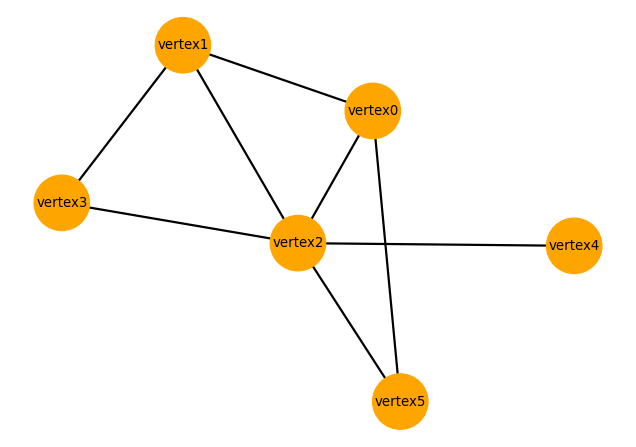

In [10]:
the_more_complex_graph = nx.Graph(more_complex_graph)
show_weighted_graph(the_more_complex_graph, 2500, 12, (10,7))

The weights contained inside the dictionary are not displayed. That's because the library expects a specific format like the following:

`{"nodeA" : {"nodeB" : {"weight" : 10}}}`

Let's try:

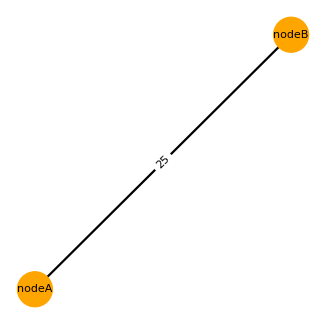

In [11]:
show_weighted_graph(nx.Graph({"nodeA" : {"nodeB" : {"weight" : 25}}}), 1000, 10, (5,5))

**Q. By filling the gaps below, reformat `more_complex_graph` in order to display it properly (with the weights).**

#### <font color='blue'> Solution </font>

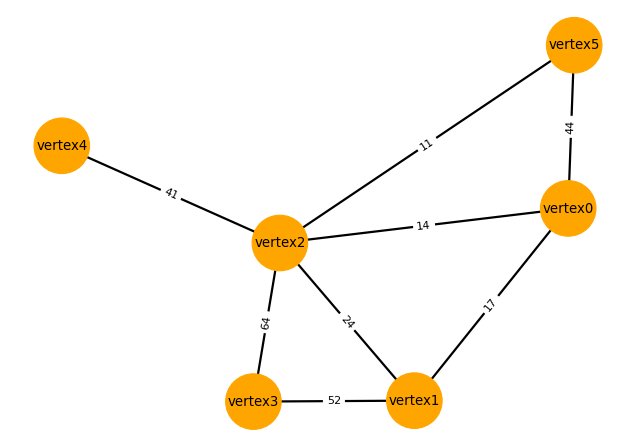

In [12]:
# Your code to transform the more_complex_graph to something that can be
# given as input of nx.Graph() and be displayed properly (with the weights)

more_complex_dict = dict()

for node, connected_elem in more_complex_graph.items():
  temp_dict = dict()
  for connected_node, connection_weight in connected_elem.items():
    temp_dict[connected_node] = {"weight" : connection_weight}
  more_complex_dict[node] = temp_dict


show_weighted_graph(nx.Graph(more_complex_dict), 2500, 12, (10,7))

Besides nice visualisation, `networkX` provides a lot of functions that are going to make our life easier. It can for instance give us the number of nodes (`<graph>.number_of_nodes()`), number of edges (`<graph>.number_of_edges()`), the name and values of nodes and edges (`list(<graph>.edges())` and `list(<graph>.nodes())`), the neighbours of a given node (`list(<graph>.neighbors(<node_name>))`), adjacencies and so on.

For more information you can have a look at the documentation [here](https://networkx.github.io/documentation/stable/tutorial.html#).

Now that we are a bit familiar with how to work with graphs using python, let's tackle some problems!

## 1. Find your way out!

One of the main application of tree search algorithms is to find a path between an intial state to a goal state. There are many problems that can be modelled in this framework, but in our first example, we are simply going to find our way out of a given labyrinth!


Before proceeding with the rest of the exercises, **double check if the other auxiliary files are available in the same folder of this notebook**. The files include three data files with `json` extension and some (labyrinth) images.  If you don't remember how, refer to the previous lab manual, or just ask a demonstrator.

### 1.1. First steps

In this subsection you are going to find a path between the entrance (top left corner) and the exit (bottom right corner) of a given labyrinth using **BFS** and **DFS** algorithms.

![Image of the first labyrinth](https://drive.google.com/uc?id=1h-IV8LNcAV2_c3IIIuOOJONjZCBz2bZw)

The graph corresponding to this labyrinth is provided in the file **`small_labyrinth.json`**. Let's load it:

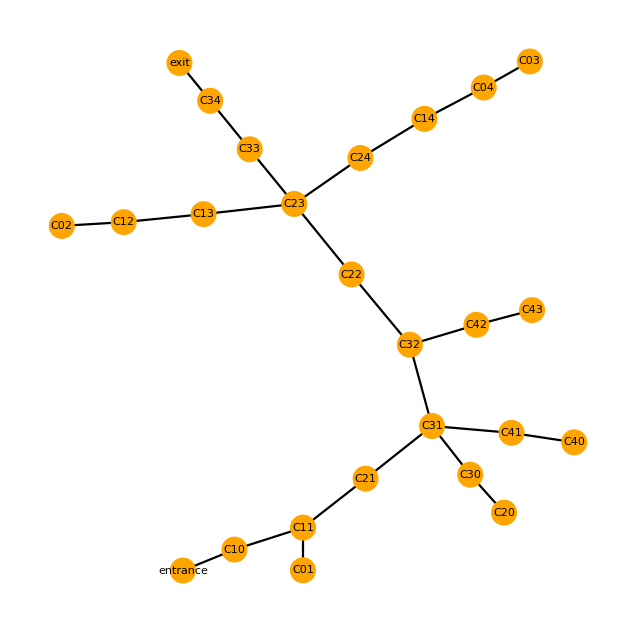

In [13]:
import json

def load_graph_from_file(filename):
  with open(filename) as labyrinth_file:
    dict_labyrinth = json.load(labyrinth_file)
    return nx.Graph(dict_labyrinth)

small_labyrinth = load_graph_from_file("small_labyrinth.json")
show_weighted_graph(small_labyrinth, 500, 10, (10,10))

The cells named `entrance` and `exit` are self-explanatory and are respectively equivalent to `C00` and `C44`. All the other cells are named `CXY` where `X` corresponds to the row and `Y` column of the cell in the image.


*NOTE: In this simple exercise, the arguably more difficult part is already done for us, which is to abstract the original problem (finding an exit path in a labyrinth) and cast is as a tree/graph search problem. This might not be the case in your coursework/exams, so take a moment to ponder about how this abstraction worked, and if you could have done it yourself.*

### 1.2. Depth First Search (DFS)

**Q. By filling the gaps below, write two python functions (a non-recursive and a recursive one) each returning a solution: a list of nodes composing the path found by DFS from the starting node to the node representing the goal state (including both). Alternatively, you can also return a list composing the edges that represent a solution path. Add the functionality to reverse the order of the explored nodes at each level.**

*Hint: In your code, you can take advantage of the method `<graph>.neighbors(<node_name>)` to find which nodes are connected to another.*



#### <font color='blue'> Solution DFS -- variation 1</font>

In [14]:
# Your function implementing DFS
def construct_path_from_root(node, root):
    """the non-recursive way!"""

    path_from_root = [node['label']]
    while node['parent']:
        node = node['parent']
        path_from_root = [node['label']] + path_from_root
    return path_from_root


def my_depth_first_graph_search(nxobject, initial, goal, compute_exploration_cost=False, reverse=False):
    """the no-oop way!"""

    frontier = [{'label':initial, 'parent':None}]
    explored = {initial}
    number_of_explored_nodes = 0

    while frontier:
        node = frontier.pop() # pop from the right of the list
        # print the node that has just been explored
        #print('-> ' + node['label'])
        number_of_explored_nodes += 1
        if node['label']==goal:
            if compute_exploration_cost:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])

        for child_label in neighbours:
            child = {'label':child_label, 'parent':node}
            if child_label not in explored:
                frontier.append(child) # added to the right of the list, so it is a LIFO
                explored.add(child_label)
    return None

You can now call your function with `small_labyrinth` (the example graph object we constructed before, representing our small labyringth), `"entrance"` and `"exit"` as test arguments. Print the output list, and check if it should return `["entrance", "C10", "C11", "C21", "C31", "C32", "C22", "C23", "C33", "C34", "exit"]`.

In [15]:
# You can call your function like this:
#solution = my_depth_first_graph_search(small_labyrinth, 'entrance', 'exit')
solution = my_depth_first_graph_search(small_labyrinth, 'entrance', 'exit', compute_exploration_cost=True)
construct_path_from_root(solution, 'entrance')

number of explorations = 13


['entrance',
 'C10',
 'C11',
 'C21',
 'C31',
 'C32',
 'C22',
 'C23',
 'C33',
 'C34',
 'exit']

#### <font color='blue'> Solution DFS -- variation 2</font>

In [16]:
def my_recursive_dfs_implementation(graph, origin, destination, already_visited = [], count=0, reverse=False):
  """
    Recursive way to implement DFS
  """
  # If I reach destination, I finish right here, return list with the final place
  if origin == destination:
    return [origin],count+1

  next_already_visited = already_visited.copy()
  # Add current place to already_visited
  next_already_visited.append(origin)
  # print the node that has just been explored
  #print('->' + origin)
  count+=1

  neighbours = reversed(list(graph.neighbors(origin))) if not reverse else graph.neighbors(origin)

  # Check all possible destinations from where I am
  for next_node in neighbours:
    # Will only go if I havent gone before (No Loops nor going back)
    if next_node not in next_already_visited:
      # Go to first node possible
      result, count= my_recursive_dfs_implementation(graph, next_node, destination, next_already_visited, count, reverse)
      # If not dead end, means I found. Otherwise try next node
      if result != []:
        path = [origin] + result
        return path,count

  # If no node works, I return empty string which would mean dead end
  return [],count

In [17]:
#path, _ = my_recursive_dfs_implementation(small_labyrinth, 'entrance', 'exit')
path, count = my_recursive_dfs_implementation(small_labyrinth, 'entrance', 'exit')
print(path)
print('number of explorations = {}'.format(count))

['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']
number of explorations = 13


### 1.3. Breadth First Search (BFS)


**Q. By filling the gaps below, write two functions (an implementation with a queue and an implementation with a list) taking the same inputs as before but returning the list containing the nodes that represent the path found by BFS.**

#### <font color='blue'> Solution BFS -- variation 1</font>

In [18]:
# Your function implmenting BFS

def my_breadth_first_graph_search(nxobject, initial, goal, compute_exploration_cost=False, reverse=False):

    if initial == goal: # just in case, because now we are checking the children
        return None

    number_of_explored_nodes = 0
    frontier = [{'label':initial, 'parent':None}]
    # FIFO queue should NOT be implemented with a list, this is slow! better to use deque
    explored = {initial}

    while frontier:
        node = frontier.pop() # pop from the right of the list
        number_of_explored_nodes += 1

        # print the node that has just been explored
        # print('-> ' + node['label'])

        # goal check
        if node['label']==goal:
            if compute_exploration_cost:
                print('number of explorations = {}'.format(number_of_explored_nodes))
            return node

        neighbours = reversed(list(nxobject.neighbors(node['label']))) if reverse else nxobject.neighbors(node['label'])

        for child_label in neighbours:
            child = {'label':child_label, 'parent':node}
            if child_label not in explored:
                frontier = [child] + frontier # added to the left of the list, so a FIFO!
                explored.add(child_label)
    return None

Calling your new function with the same input as before, (`small_labyrinth`, `"entrance"` and `"exit"`) you should find exactly the same output: `["entrance", "C10", "C11", "C21", "C31", "C32", "C22", "C23", "C33", "C34", "exit"]`


In [19]:
# You can call your function like this:
solution = my_breadth_first_graph_search(small_labyrinth, 'entrance', 'exit', compute_exploration_cost=True)
construct_path_from_root(solution, 'entrance')

number of explorations = 24


['entrance',
 'C10',
 'C11',
 'C21',
 'C31',
 'C32',
 'C22',
 'C23',
 'C33',
 'C34',
 'exit']

#### <font color='blue'> Solution BFS -- variation 2</font>

In [20]:
def bfs_implementation(graph, origin, destination, counter = 0, reverse=False):
  # Add current place to already_visited
  next_already_visited = [origin]
  # List of existent paths (for now only origin)
  total_paths = [[origin]]

  # Will perform exploration of all current paths
  while len(total_paths)!= 0:
    new_total_paths = []
    # I check every single existing path for now
    for path in total_paths:
      # Last element in path, where to go next?
      last_element_in_path = path[-1]
      counter += 1

      # print the node that has just been explored
      # print('-> ' + last_element_in_path)

      # goal check
      if destination in last_element_in_path:
        # Result complete, will return this path with destination at end
        return path, counter

      # Nodes connected to here...
      nodes_found = list(reversed(list(graph.neighbors(last_element_in_path)))) if reverse else list(graph.neighbors(last_element_in_path))

      # Otherwise, I'll need to explore the nodes connected to here...
      for node in nodes_found:
        # I only will consider nodes not visited before (avoid loops and going back)
        if node not in next_already_visited:
          # this node will be out of limits for next explorations
          next_already_visited.append(node)
          # I add this possible path for further exploration
          new_total_paths = new_total_paths + [path + [node]]
    # At the end, I need to explore only these "new" paths, until I reach destination, or run out of possible valid paths
    total_paths = new_total_paths

  # If no more possible paths, means solution does not exist
  return [],-1

In [21]:
#bfs_path, _ = bfs_implementation(small_labyrinth, 'entrance', 'exit')
bfs_path, count = bfs_implementation(small_labyrinth, 'entrance', 'exit')
print(bfs_path)
print('number of explorations = {}'.format(count))

['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']
number of explorations = 24


### 1.4. A bit of analysis

You might wonder why we should implement both BFS and DFS if they output exactly the same path at the end. If it's not already clear, let's investigate a bit more:

**Q. Modify your code so that it also returns the number of nodes visited along with the solution path. Then run the analysis below.**

#### <font color='blue'> Solution BFS and DFS -- variation 1</font>

In [22]:
solution_bfs = my_breadth_first_graph_search(small_labyrinth, 'entrance', 'exit', True)
solution_dfs = my_depth_first_graph_search(small_labyrinth, 'entrance', 'exit', True)

number of explorations = 24
number of explorations = 13


#### <font color='blue'> Solution BFS and DFS -- variation 2</font>

In [23]:
bfs_path, number_visited_bfs = bfs_implementation(small_labyrinth, 'entrance', 'exit')
print("Number of visited for BFS: {}".format(number_visited_bfs))
dfs_path, number_visited_dfs = my_recursive_dfs_implementation(small_labyrinth, 'entrance', 'exit')
print("Number of visited for DFS: {}".format(number_visited_dfs))

Number of visited for BFS: 24
Number of visited for DFS: 13


Now, for DFS, let's change the way you pick the next node (creating a new function is a good idea). For instance, if the neighbours of a node are `[a, b, c]`, instead of visiting `a` first, let's visit `c` first.

#### <font color='blue'> Solution BFS and DFS -- variation 1</font>

In [24]:
solution_bfs2 = my_breadth_first_graph_search(small_labyrinth, 'entrance', 'exit', True, True)
solution_dfs_2 = my_depth_first_graph_search(small_labyrinth, 'entrance', 'exit', True, True)

number of explorations = 22
number of explorations = 23


#### <font color='blue'> Solution BFS and DFS -- variation 2</font>

In [25]:
bfs_path_i, number_visited_bfs_inversed = bfs_implementation(small_labyrinth, 'entrance', 'exit', reverse=True)
print("Number of visited for inversed BFS: {}".format(number_visited_bfs_inversed))
dfs_path_i, number_visited_dfs_inversed = my_recursive_dfs_implementation(small_labyrinth, 'entrance', 'exit', reverse=True)
print("Number of visited for inversed DFS: {}".format(number_visited_dfs_inversed))

Number of visited for inversed BFS: 22
Number of visited for inversed DFS: 23


If everything works well, the path returned should be exactly the same. But what about the number of cells you have visited? <br/>
Can you do the same thing with BFS? Explain why.

**A. Depending on the order we process the nodes, the efficiency of both BFS and DFS can improve, i.e. a path will be found visiting less nodes. For BFS, the improvement is typically lower than for DFS. This can be explained by the fact that BFS will find the solution at a given depth, and that it will iterate through all the nodes in the previous depth anyways. However, we cannot know before hand what is the best. Except if you can visualise the graph you are working with and already know where in the graph the goal is (which is unlikely).**

### 1.5. BFS or DFS?


The last subsection showed that how we choose to explore in DFS will impact the efficiency of the search. So why not just using BFS then? Let's try to understand why.


Let's consider a larger labyrinth! Use your two search functions that you implemented in order to find a path between `"entrance"` and `"exit"`. The graph you are going to work with corresponds to the following labyrinth:

![Image: a larger labyrinth example.](https://drive.google.com/uc?id=14KFgxnoM4P5UFSkb7Hth30YBR7QPAcRx)




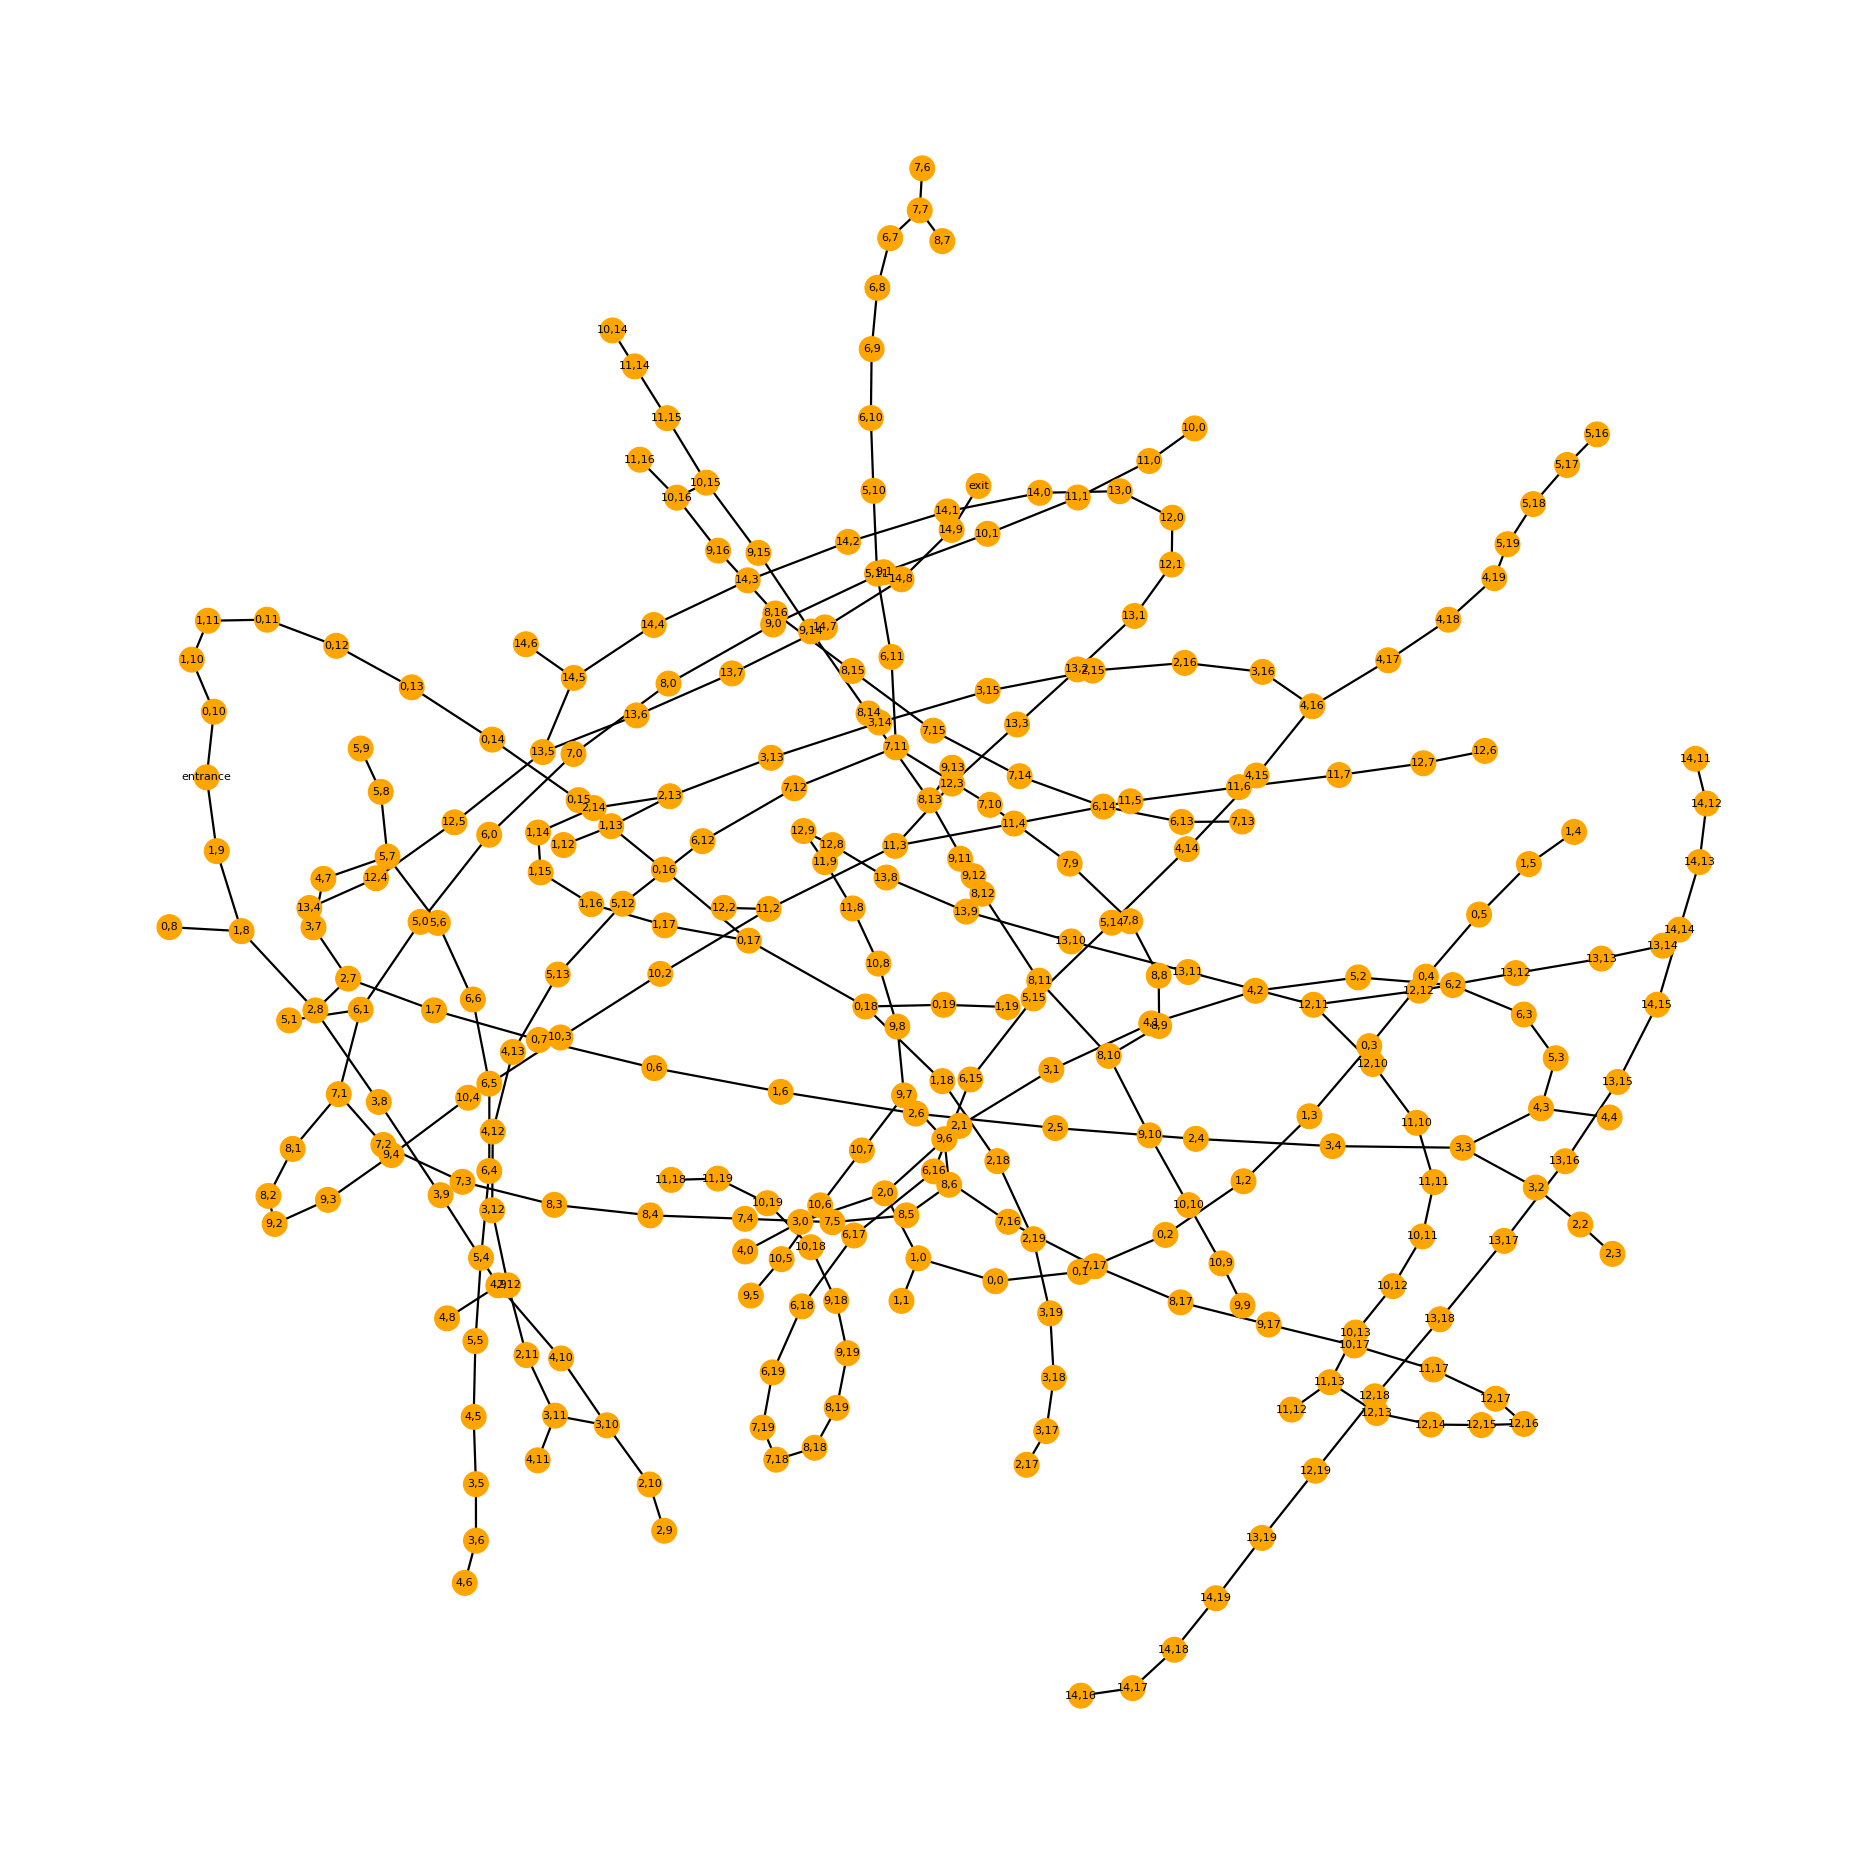

In [26]:
large_labyrinth = load_graph_from_file("large_labyrinth.json")
show_weighted_graph(large_labyrinth, 500, 10, (30, 30))

#### <font color='blue'> Solution -- variation 1</font>

In [27]:
# You can call both your BFS and DFS function in this cell with large_labyrinth, "entrance" and "exit".

print('\nUsing BFS:\n'+'='*10)
solution_bfs = my_breadth_first_graph_search(large_labyrinth, 'entrance', 'exit', True)
print(construct_path_from_root(solution_bfs, 'entrance'))

print('\nUsing DFS:\n'+'='*10)
solution_dfs = my_depth_first_graph_search(large_labyrinth, 'entrance', 'exit', True)
print(construct_path_from_root(solution_dfs, 'entrance'))



Using BFS:
number of explorations = 300
['entrance', '0,10', '1,10', '1,11', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '1,17', '1,16', '1,15', '1,14', '2,14', '2,13', '3,13', '3,14', '3,15', '2,15', '2,16', '3,16', '4,16', '4,15', '4,14', '5,14', '5,15', '6,15', '6,16', '7,16', '7,17', '8,17', '9,17', '10,17', '11,17', '12,17', '12,16', '12,15', '12,14', '12,13', '11,13', '10,13', '10,12', '10,11', '11,11', '11,10', '12,10', '12,11', '13,11', '13,10', '13,9', '13,8', '12,8', '12,9', '11,9', '11,8', '10,8', '9,8', '9,7', '9,6', '8,6', '8,5', '7,5', '7,4', '8,4', '8,3', '7,3', '7,2', '7,1', '8,1', '8,2', '9,2', '9,3', '9,4', '10,4', '10,3', '10,2', '11,2', '11,3', '12,3', '13,3', '13,2', '13,1', '12,1', '12,0', '13,0', '14,0', '14,1', '14,2', '14,3', '14,4', '14,5', '13,5', '13,6', '13,7', '14,7', '14,8', '14,9', 'exit']

Using DFS:
number of explorations = 161
['entrance', '0,10', '1,10', '1,11', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '1,17', '1,16', '1,1

#### <font color='blue'> Solution -- variation 2</font>

In [28]:
print('\nUsing BFS:\n'+'='*10)
bfs_path, number_visited_bfs = bfs_implementation(large_labyrinth, 'entrance', 'exit')
print("Number of explorations: {}".format(number_visited_bfs))
print(bfs_path)

print('\nUsing DFS:\n'+'='*10)
dfs_path, number_visited_dfs = my_recursive_dfs_implementation(large_labyrinth, 'entrance', 'exit')
print("Number of explorations: {}".format(number_visited_dfs))
print(dfs_path)


Using BFS:
Number of explorations: 300
['entrance', '0,10', '1,10', '1,11', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '1,17', '1,16', '1,15', '1,14', '2,14', '2,13', '3,13', '3,14', '3,15', '2,15', '2,16', '3,16', '4,16', '4,15', '4,14', '5,14', '5,15', '6,15', '6,16', '7,16', '7,17', '8,17', '9,17', '10,17', '11,17', '12,17', '12,16', '12,15', '12,14', '12,13', '11,13', '10,13', '10,12', '10,11', '11,11', '11,10', '12,10', '12,11', '13,11', '13,10', '13,9', '13,8', '12,8', '12,9', '11,9', '11,8', '10,8', '9,8', '9,7', '9,6', '8,6', '8,5', '7,5', '7,4', '8,4', '8,3', '7,3', '7,2', '7,1', '8,1', '8,2', '9,2', '9,3', '9,4', '10,4', '10,3', '10,2', '11,2', '11,3', '12,3', '13,3', '13,2', '13,1', '12,1', '12,0', '13,0', '14,0', '14,1', '14,2', '14,3', '14,4', '14,5', '13,5', '13,6', '13,7', '14,7', '14,8', '14,9', 'exit']

Using DFS:
Number of explorations: 161
['entrance', '0,10', '1,10', '1,11', '0,11', '0,12', '0,13', '0,14', '0,15', '0,16', '0,17', '1,17', '1,16', '1,15'

By the way, both of your algorithms should output a list corresponding to the following solution:

![alt text](https://drive.google.com/uc?id=1qTM-WlnWaUJNELzwgfpgR6qVuk-KrW9S)

Let's now carry out the same analysis as before: how many nodes have been visited using DFS? using BFS? Can you come up with a "rule" or a "trend"?


#### <font color='blue'> Solution -- variation 1</font>

In [29]:
print('\nUsing BFS:\n'+'='*10)
solution_inversed_bfs = my_breadth_first_graph_search(large_labyrinth, 'entrance', 'exit', True, True)

print('\nUsing DFS:\n'+'='*10)
solution_inversed_dfs = my_depth_first_graph_search(large_labyrinth, 'entrance', 'exit', True, True)


Using BFS:
number of explorations = 300

Using DFS:
number of explorations = 239


#### <font color='blue'> Solution -- variation 2</font>

In [30]:
print('\nUsing BFS:\n'+'='*10)
bfs_path_i, number_visited_bfs_i = bfs_implementation(large_labyrinth, 'entrance', 'exit', reverse=True)
print("Number of explorations: {}".format(number_visited_bfs_i))

print('\nUsing DFS:\n'+'='*10)
dfs_path_i, number_visited_dfs_i = my_recursive_dfs_implementation(large_labyrinth, 'entrance', 'exit', reverse=True)
print("Number of explorations: {}".format(number_visited_dfs_i))


Using BFS:
Number of explorations: 300

Using DFS:
Number of explorations: 239


### <font color='blue'> Solution </font>

**A. We can observe that on a bigger graph, both algorithms need to visit a lot of nodes before finding a solution. The number of states visited by BFS when we reverse the order of nodes we process is typically the same. However, for DFS a more drastic change is typically observed. This behaviour is consistent with what has been conjectured before.**

Note that in both scenarios, DFS visits less states. The difference is even more obvious with big labyrinth with a lot of walls. On one hand, BFS ensures you to get the optimal solution on an non-weighted graph and is less efficient on trees with an important branching factor. On the other hand, DFS is more efficient in such problems but might explore more solutions than BFS if the graph is very deep.

# 2. Limits of BFS and DFS


In the previous examples, except for the number of nodes visited before finding the solution path, we cannot intuitively evaluate whether the solution path is good or bad since there exists exactly only one path (the solution is unique).

In some other problems, just finding a solution path is not enough or interesting, and we rather want to find the best possible solution (the one with the lowest cost).

For instance, let's say for travelling from city A to city B, most of the travellers would prefer taking the shortest path. Let's see if BFS and DFS can help in such scenarios.

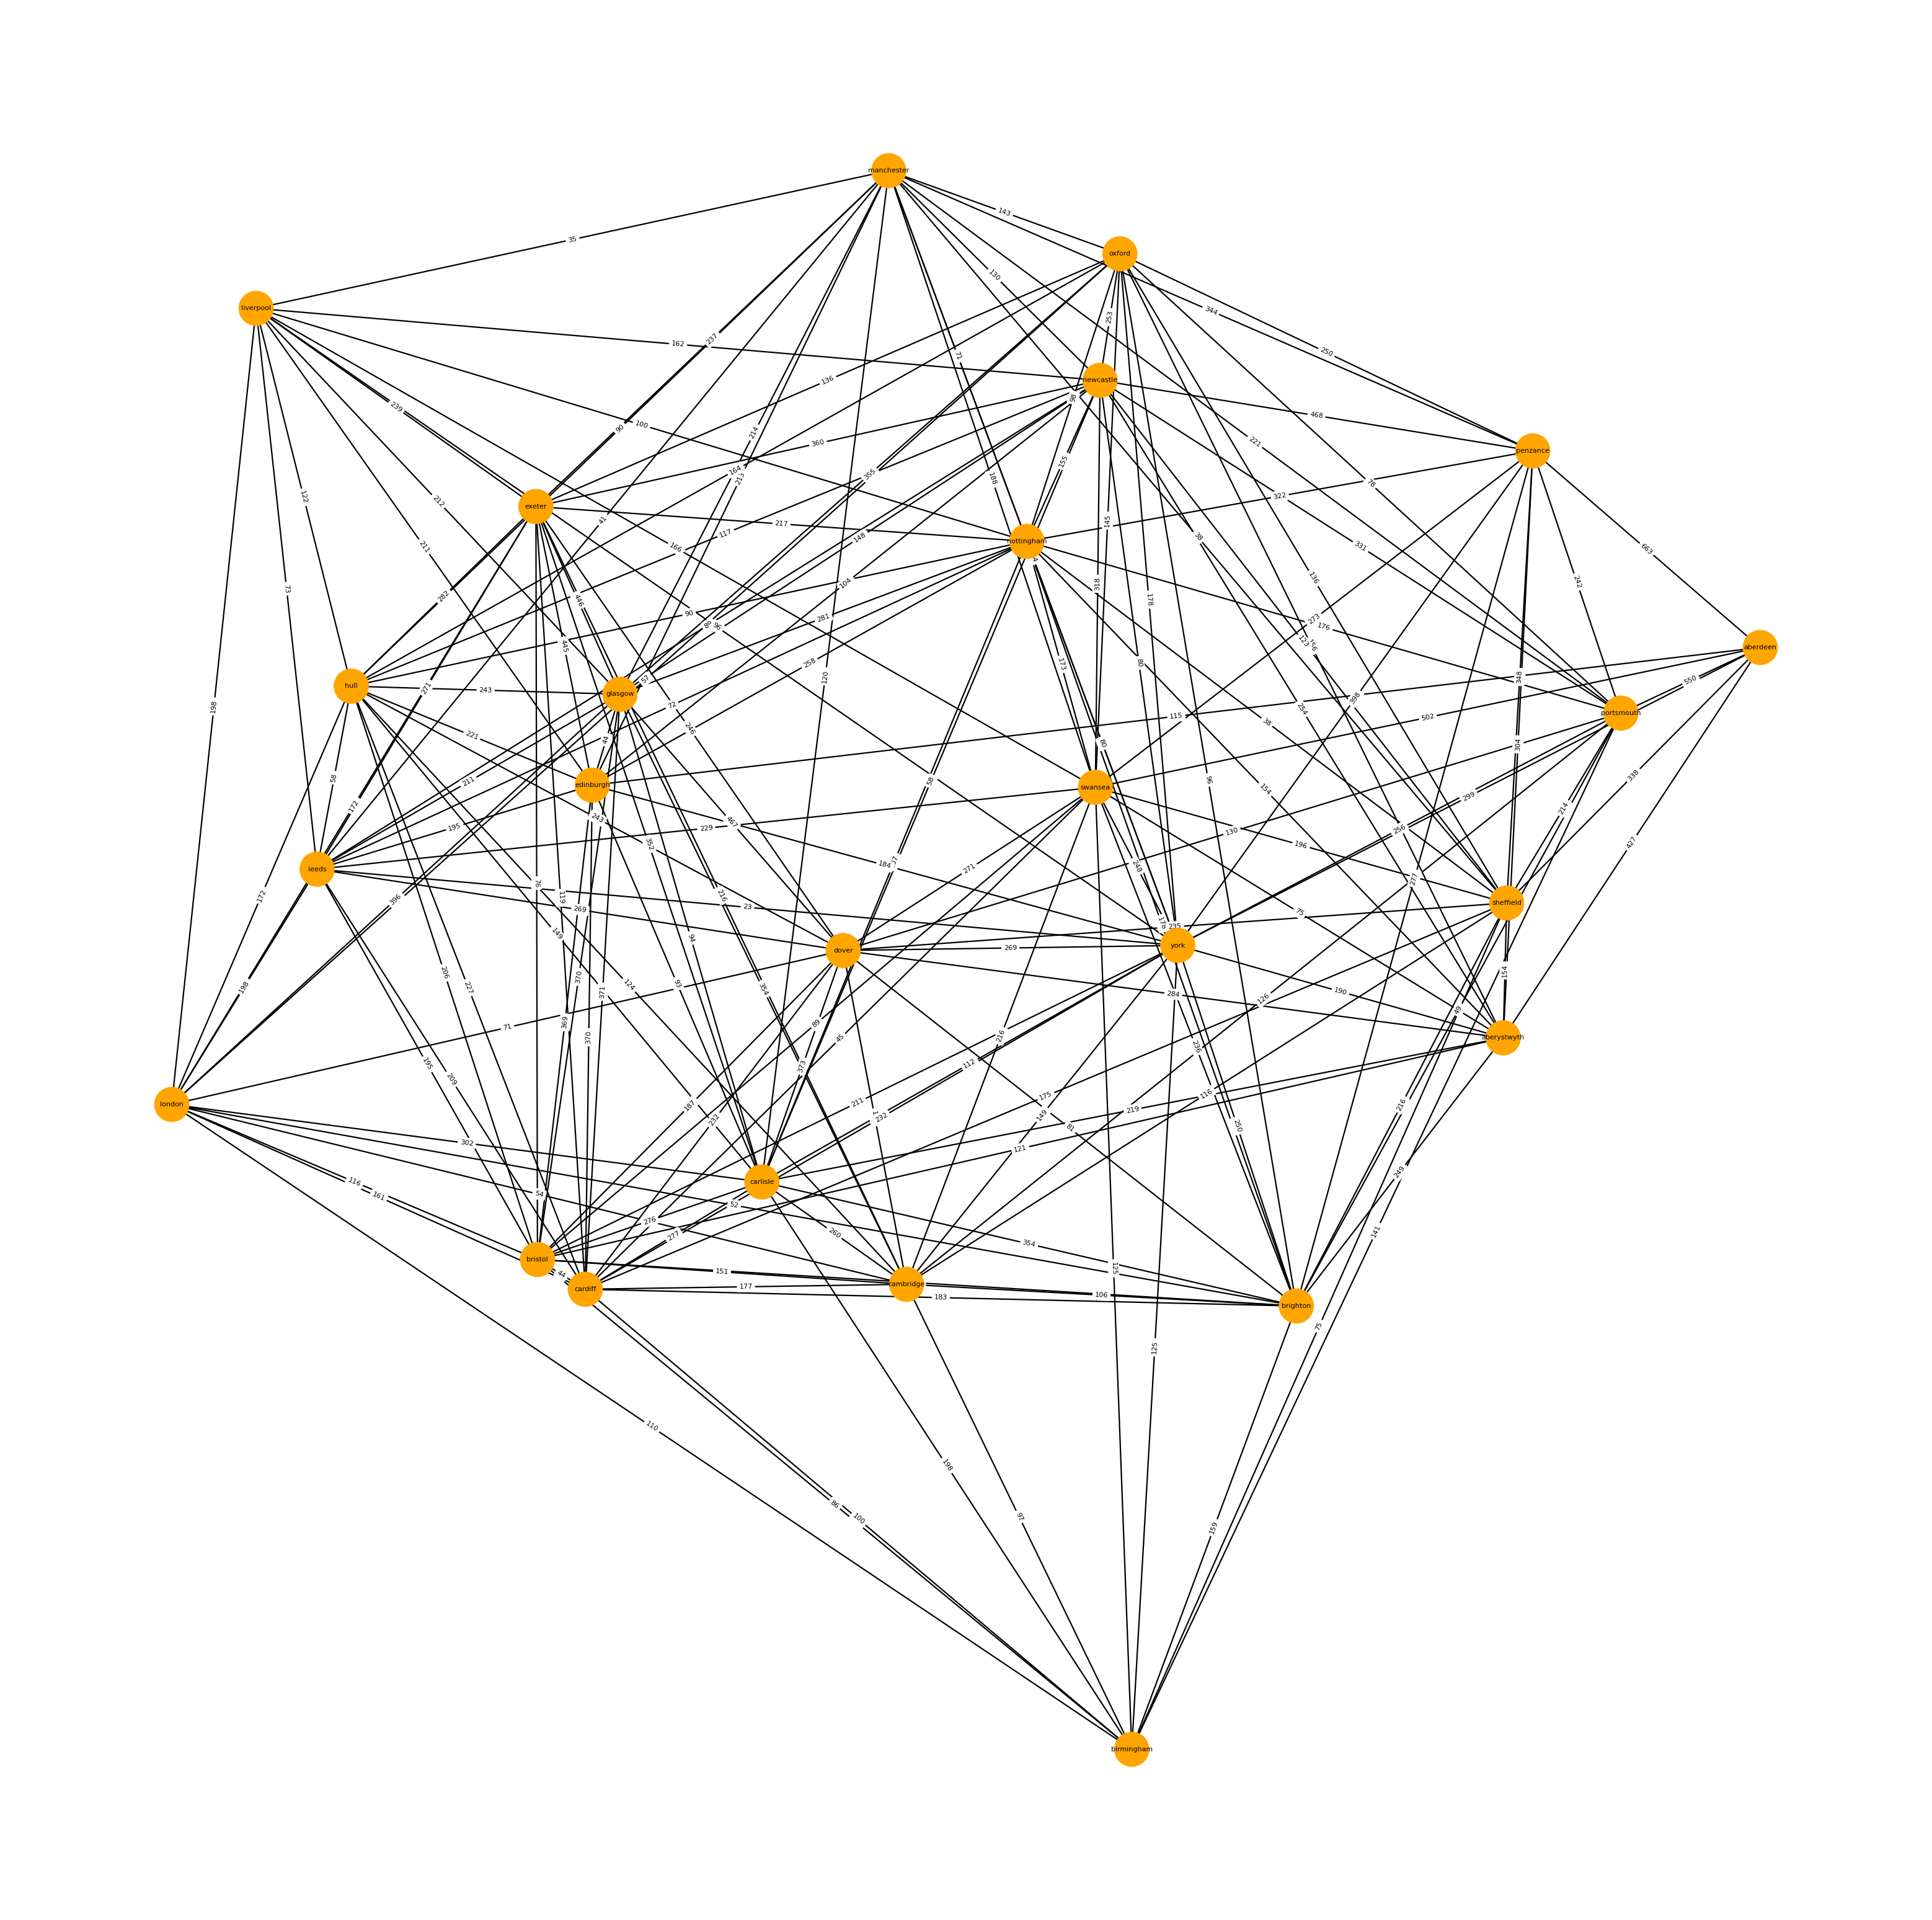

In [31]:
uk_cities = load_graph_from_file("UK_cities.json")
show_weighted_graph(uk_cities, 2500, 10, (50, 50))

Run both your DFS and BFS on this graph in order to find a path between London and Aberdeen. The arguments should be `"uk_cities", "london"` and `"aberdeen"`.



#### <font color='blue'> Solution -- variation 1</font>

In [32]:
# Code to run and compute the cost of the path found by DFS and BFS
solution_bfs_ = my_breadth_first_graph_search(uk_cities, 'london', 'aberdeen', True)
print("Path found by BFS: {}".format(construct_path_from_root(solution_bfs_, 'london')))
solution_dfs_ = my_depth_first_graph_search(uk_cities, 'london', 'aberdeen', True)
print("Path found by DFS: {}".format(construct_path_from_root(solution_dfs_, 'london')))

number of explorations = 25
Path found by BFS: ['london', 'birmingham', 'portsmouth', 'aberdeen']
number of explorations = 5
Path found by DFS: ['london', 'oxford', 'york', 'aberdeen']


In [33]:
# Code to run and compute the cost of the path found by DFS and BFS
solution_bfs_i = my_breadth_first_graph_search(uk_cities, 'london', 'aberdeen', True, True)
print("Path found by inversed BFS: {}".format(construct_path_from_root(solution_bfs_i, 'london')))
solution_dfs_i = my_depth_first_graph_search(uk_cities, 'london', 'aberdeen', True, True)
print("Path found by inversed DFS: {}".format(construct_path_from_root(solution_dfs_i, 'london')))

number of explorations = 25
Path found by inversed BFS: ['london', 'oxford', 'york', 'aberdeen']
number of explorations = 4
Path found by inversed DFS: ['london', 'birmingham', 'portsmouth', 'aberdeen']


#### <font color='blue'> Solution -- variation 2</font>

In [34]:
bfs_path, number_visited_bfs = bfs_implementation(uk_cities, 'london', 'aberdeen')
print("Number of explorations: {}".format(number_visited_bfs))
print("Path found by BFS: {}".format(bfs_path))
dfs_path, number_visited_dfs = my_recursive_dfs_implementation(uk_cities, 'london', 'aberdeen')
print("Number of explorations: {}".format(number_visited_dfs))
print("Path found by DFS: {}".format(dfs_path))

Number of explorations: 25
Path found by BFS: ['london', 'birmingham', 'portsmouth', 'aberdeen']
Number of explorations: 25
Path found by DFS: ['london', 'oxford', 'york', 'swansea', 'sheffield', 'portsmouth', 'penzance', 'nottingham', 'newcastle', 'manchester', 'liverpool', 'leeds', 'hull', 'glasgow', 'exeter', 'edinburgh', 'carlisle', 'dover', 'cardiff', 'cambridge', 'bristol', 'brighton', 'aberystwyth', 'aberdeen']


In [35]:
bfs_path_i, number_visited_bfs_i = bfs_implementation(uk_cities, 'london', 'aberdeen', reverse=True)
print("Number of explorations: {}".format(number_visited_bfs_i))
print("Path found by BFS: {}".format(bfs_path_i))
dfs_path_i, number_visited_dfs_i = my_recursive_dfs_implementation(uk_cities, 'london', 'aberdeen', reverse=True)
print("Number of explorations: {}".format(number_visited_dfs_i))
print("Path found by DFS: {}".format(dfs_path_i))

Number of explorations: 25
Path found by BFS: ['london', 'oxford', 'york', 'aberdeen']
Number of explorations: 5
Path found by DFS: ['london', 'birmingham', 'brighton', 'aberystwyth', 'aberdeen']


Compute the cost of the path found by each algorithm. Can you guarantee that you have the shortest path? Explain why.

In [36]:
def compute_path_cost(graph, path):
  """
    Compute cost of a path
  """
  cost = 0
  for index_city in range(len(path) - 1):
    cost += graph[path[index_city]][path[index_city + 1]]["weight"]
  return cost

#### <font color='blue'> Solution -- variation 1</font>

<font color='blue'> For this implementation, we only have two generated paths </font>

In [37]:
path_one = construct_path_from_root(solution_dfs_, 'london')
path_two = construct_path_from_root(solution_dfs_i, 'london')

first_path_cost = compute_path_cost(uk_cities, path_one)
second_path_cost = compute_path_cost(uk_cities, path_two)

print("Cost for path {}: {}".format(path_one, first_path_cost))
print("Cost for path {}: {}".format(path_two, second_path_cost))

Cost for path ['london', 'oxford', 'york', 'aberdeen']: 534
Cost for path ['london', 'birmingham', 'portsmouth', 'aberdeen']: 801


#### <font color='blue'> Solution -- variation 2</font>

<font color='blue'> For this implementation, we have four different paths </font>

In [38]:
bfs_cost_path = compute_path_cost(uk_cities, bfs_path)
dfs_cost_path = compute_path_cost(uk_cities, dfs_path)
inversed_bfs_cost_path = compute_path_cost(uk_cities, bfs_path_i)
inversed_dfs_cost_path = compute_path_cost(uk_cities, dfs_path_i)

print("Cost for BFS path {}: {}".format(bfs_path, bfs_cost_path))
print("Cost for DFS path {}: {}".format(dfs_path, dfs_cost_path))
print("Cost for inversed BFS path {}: {}".format(bfs_path_i, inversed_bfs_cost_path))
print("Cost for inversed DFS path {}: {}".format(dfs_path_i, inversed_dfs_cost_path))

Cost for BFS path ['london', 'birmingham', 'portsmouth', 'aberdeen']: 801
Cost for DFS path ['london', 'oxford', 'york', 'swansea', 'sheffield', 'portsmouth', 'penzance', 'nottingham', 'newcastle', 'manchester', 'liverpool', 'leeds', 'hull', 'glasgow', 'exeter', 'edinburgh', 'carlisle', 'dover', 'cardiff', 'cambridge', 'bristol', 'brighton', 'aberystwyth', 'aberdeen']: 4880
Cost for inversed BFS path ['london', 'oxford', 'york', 'aberdeen']: 534
Cost for inversed DFS path ['london', 'birmingham', 'brighton', 'aberystwyth', 'aberdeen']: 945


**A. Applying both variations of the same algorithm on such complex graph shows that the implementation can change the result. As a matter of fact, so far we were working with graphs or trees in which we only had one way to find the path. Here different solution paths are possible. So the order of process of the nodes is an important factor. However it is impossible to guarantee that the path provided by any BFS or DFS outputs the path with the minimalist cost since this cost information is never used when determining the path. Note that BFS would ensure to get the path with the least cities but NOT the path with the optimal cost.**